In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist as fmnist
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout


<h3>Loading the train test splits for fashion_mnist</h3>

In [ ]:
(train_X, train_y), (test_X, test_y) = fmnist.load_data()
print(np.shape(train_X))

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)


<h3>Preprocessing data</h3>

In [ ]:
def normalize(image):
    
    image = tf.cast(image, dtype=float)/255

    return image

def one_hot_matrix(labels, depth = 10):
    
    one_hot = tf.reshape(tf.one_hot(labels, depth, axis = 0), [-1,])
    
    return one_hot

train_X = tf.data.Dataset.from_tensor_slices(train_X)
train_y = tf.data.Dataset.from_tensor_slices(train_y)

test_X = tf.data.Dataset.from_tensor_slices(test_X)
test_y = tf.data.Dataset.from_tensor_slices(test_y)

new_train_X = train_X.map(normalize)
new_test_X = test_X.map(normalize)

new_train_y = train_y.map(one_hot_matrix)
new_test_y = test_y.map(one_hot_matrix)

train_datset = tf.data.Dataset.zip((new_train_X, new_train_y)).batch(64).prefetch(6)
test_datset = tf.data.Dataset.zip((new_test_X, new_test_y)).batch(64).prefetch(6)


<h3>Conv Block</h3>

In [20]:
def ConvBlock(prev, filter_size, num_filters, drop = True, padding = 'valid', pool = True):

  X = Conv2D(num_filters, kernel_size = (filter_size,filter_size), strides = (1,1), use_bias = True, padding = padding, kernel_initializer = 'glorot_normal', kernel_regularizer = 'l2')(prev)

  X = LeakyReLU()(X)

  X = BatchNormalization(axis = 3, trainable = True)(X)

  if pool == True:
    X = MaxPool2D(pool_size= (2,2), strides = (2,2))(X)

  if drop == True:
    X = Dropout(0.2)(X)

  return X

<h3>Defining the Model</h3>

In [21]:
def Classifier_model(input_shape):

  input_img = tf.keras.Input(shape = input_shape)

  CBlock1 = ConvBlock(input_img, filter_size=4, num_filters=256, padding='same')

  CBlock2 = ConvBlock(CBlock1, filter_size=4, num_filters=128, pool=False)

  CBlock3 = ConvBlock(CBlock2, filter_size=2, num_filters=128, padding='same')

  CBlock4 = ConvBlock(CBlock3, filter_size=2, num_filters=64)

  Flat = Flatten()(CBlock4)

  outputs = Dense(units = 10, activation = 'softmax')(Flat)

  model = tf.keras.Model(inputs = input_img, outputs = outputs)   

  return model


<h3>Creating the Model Object</h3>

In [22]:
Model = Classifier_model((28,28,1))
Model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
Model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       4352      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 256)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 256)       0   

<h3>Training the Model</h3>

In [23]:
device_name = tf.test.gpu_device_name()
print(device_name)

with tf.device('/device:GPU:0'):
    history = Model.fit(train_datset, epochs = 40, validation_data = test_datset)


/device:GPU:0
Epoch 1/40
938/938 [==============================] - 20s 20ms/step - loss: 1.5655 - accuracy: 0.7993 - val_loss: 0.7414 - val_accuracy: 0.8326
Epoch 2/40
938/938 [==============================] - 19s 20ms/step - loss: 0.6663 - accuracy: 0.8387 - val_loss: 0.9393 - val_accuracy: 0.7521
Epoch 3/40
938/938 [==============================] - 18s 19ms/step - loss: 0.6357 - accuracy: 0.8470 - val_loss: 0.9190 - val_accuracy: 0.7664
Epoch 4/40
938/938 [==============================] - 18s 19ms/step - loss: 0.6207 - accuracy: 0.8494 - val_loss: 0.8366 - val_accuracy: 0.7808
Epoch 5/40
938/938 [==============================] - 18s 19ms/step - loss: 0.6139 - accuracy: 0.8535 - val_loss: 0.9000 - val_accuracy: 0.7729
Epoch 6/40
938/938 [==============================] - 18s 19ms/step - loss: 0.5932 - accuracy: 0.8560 - val_loss: 0.7193 - val_accuracy: 0.8160
Epoch 7/40
938/938 [==============================] - 18s 19ms/step - loss: 0.5791 - accuracy: 0.8549 - val_loss: 0.6494 -

<h3>Visualizing Model Loss and Model Accuracy over training</h3>

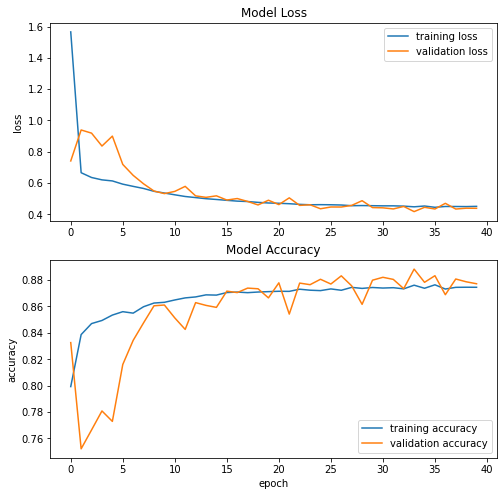

In [24]:
import pandas as pd

history = pd.DataFrame(history.history)

history.rename(columns = {'loss':'training loss', 'val_loss':'validation loss', 'accuracy':'training accuracy', 'val_accuracy': 'validation accuracy'}, inplace=True)

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(history['training loss'], label = 'training loss')
plt.plot(history['validation loss'], label = 'validation loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.legend(loc = 'upper right')

plt.subplot(2,1,2)
plt.plot(history['training accuracy'], label = 'training accuracy')
plt.plot(history['validation accuracy'], label = 'validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')


<h3>Saving the Model</h3>

In [25]:
Model.save('Model')

INFO:tensorflow:Assets written to: Model/assets


In [26]:
!zip -r /content/Model.zip /content/Model

  adding: content/Model/ (stored 0%)
  adding: content/Model/saved_model.pb (deflated 90%)
  adding: content/Model/keras_metadata.pb (deflated 93%)
  adding: content/Model/assets/ (stored 0%)
  adding: content/Model/variables/ (stored 0%)
  adding: content/Model/variables/variables.data-00000-of-00001 (deflated 5%)
  adding: content/Model/variables/variables.index (deflated 72%)


<h3>Notes for the first v2.1 of the Model</h3>

I increased the regularization to solve the variance problem in the previous version of the model. But, I may have added a loot of regularization to the model which led to an increased bias. Next, I will try decreasing the regularization to increase the performance and later, maybe using ResNet blocks.